# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [18]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from imageio import imread
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from skimage.transform import resize as imresize


We set the random seed so that the results don't vary drastically.

In [19]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [20]:
tf.__version__

'2.12.0'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [21]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 64 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [22]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,3) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(50,50))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    image = imresize(image,(50,50))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [23]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


Source path =  Project_data/train ; batch size = 64


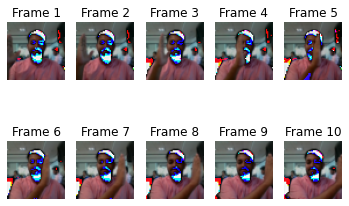

Label: 0


In [17]:
#Testing generator function
#test_gen = generator(train_path, train_doc, batch_size)
#d = next(test_gen)[0]
data_gen = generator(train_path, train_doc, batch_size)

# Fetch a batch from the generator
batch_data, batch_labels = next(data_gen)

# Display the images from the first batch
#for i in range(batch_size):
for j in range(len(batch_data[0])):
    plt.subplot(2, 5, j+1)
    plt.imshow(batch_data[i, j].astype(np.uint8))
    plt.axis('off')
    plt.title(f'Frame {j+1}')

plt.show()
print(f'Label: {np.argmax(batch_labels[i])}')

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [49]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization, Activation, Dropout, GRU, Flatten, Bidirectional, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

num_classes = 5
seq_idx = range(7,26,2)
dim_x, dim_y = 120, 120
#input_shape=(10, 50, 50, 3)
input_shape = (len(seq_idx), dim_x, dim_y, 3)

In [51]:
### Experiment 2
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

In [52]:
### Experiment 3
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

In [53]:
### Experiment 4
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

In [54]:
### Experiment 5 - Final Model
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model.add(BatchNormalization())
model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model.add(BatchNormalization())
model.add(TimeDistributed(
Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [55]:
optimiser = optimizers.Adam(lr=0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 118, 118, 8)  224       
 tributed)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 10, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 10, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [56]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [57]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01) # write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [58]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [59]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=1, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64
11/11 [==============================] - ETA: 0s - loss: 1.3232 - categorical_accuracy: 0.4525 Source path =  Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2024-01-0116_30_06.270504\model-00001-1.32321-0.45249-1.72038-0.23000.h5
11/11 [==============================] - 196s 18s/step - loss: 1.3232 - categorical_accuracy: 0.4525 - val_loss: 1.7204 - val_categorical_accuracy: 0.2300 - lr: 0.0100


In [61]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.1624 - categorical_accuracy: 0.9321
Epoch 1: saving model to model_init_2024-01-0116_30_06.270504\model-00001-0.16245-0.93213-1.30593-0.47000.h5
11/11 [==============================] - 84s 8s/step - loss: 0.1624 - categorical_accuracy: 0.9321 - val_loss: 1.3059 - val_categorical_accuracy: 0.4700 - lr: 0.0100
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.1868 - categorical_accuracy: 0.9336
Epoch 2: saving model to model_init_2024-01-0116_30_06.270504\model-00002-0.18678-0.93363-1.55169-0.48000.h5
11/11 [==============================] - 92s 9s/step - loss: 0.1868 - categorical_accuracy: 0.9336 - val_loss: 1.5517 - val_categorical_accuracy: 0.4800 - lr: 0.0100
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.1394 - categorical_accuracy: 0.9457
Epoch 3: saving model to model_init_2024-01-0116_30_06.270504\model-00003-0.13935-0.94570-0.80635-0.71000.h5
11/11 [================

11/11 [==============================] - ETA: 0s - loss: 0.0144 - categorical_accuracy: 0.9970
Epoch 22: saving model to model_init_2024-01-0116_30_06.270504\model-00022-0.01440-0.99698-0.44037-0.86000.h5

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.001.
11/11 [==============================] - 100s 9s/step - loss: 0.0144 - categorical_accuracy: 0.9970 - val_loss: 0.4404 - val_categorical_accuracy: 0.8600 - lr: 0.0020
Epoch 23/50
11/11 [==============================] - ETA: 0s - loss: 0.0110 - categorical_accuracy: 1.0000
Epoch 23: saving model to model_init_2024-01-0116_30_06.270504\model-00023-0.01103-1.00000-0.34152-0.89000.h5
11/11 [==============================] - 108s 10s/step - loss: 0.0110 - categorical_accuracy: 1.0000 - val_loss: 0.3415 - val_categorical_accuracy: 0.8900 - lr: 0.0010
Epoch 24/50
11/11 [==============================] - ETA: 0s - loss: 0.0112 - categorical_accuracy: 1.0000
Epoch 24: saving model to model_init_2024-01-0116_30_06.270504\model-00024

11/11 [==============================] - ETA: 0s - loss: 0.0058 - categorical_accuracy: 1.0000
Epoch 43: saving model to model_init_2024-01-0116_30_06.270504\model-00043-0.00576-1.00000-0.29923-0.90000.h5
11/11 [==============================] - 92s 9s/step - loss: 0.0058 - categorical_accuracy: 1.0000 - val_loss: 0.2992 - val_categorical_accuracy: 0.9000 - lr: 0.0010
Epoch 44/50
11/11 [==============================] - ETA: 0s - loss: 0.0077 - categorical_accuracy: 0.9985
Epoch 44: saving model to model_init_2024-01-0116_30_06.270504\model-00044-0.00768-0.99849-0.26989-0.92000.h5
11/11 [==============================] - 115s 11s/step - loss: 0.0077 - categorical_accuracy: 0.9985 - val_loss: 0.2699 - val_categorical_accuracy: 0.9200 - lr: 0.0010
Epoch 45/50
11/11 [==============================] - ETA: 0s - loss: 0.0093 - categorical_accuracy: 0.9970
Epoch 45: saving model to model_init_2024-01-0116_30_06.270504\model-00045-0.00927-0.99698-0.41511-0.90000.h5
11/11 [====================